In [1]:
import os
import argparse
from tqdm import tqdm
import numpy as np
import cv2
import torch
from torch import nn
from torchvision import transforms

from dataset import get_loader
from models.GCoNet_plus import GCoNet_plus
from util import save_tensor_img
from config import Config
import matplotlib.pyplot as plt

e:\Miniconda\envs\cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args():
    def __init__(self):
        self.size = 256
        self.ckpt = 'ckpt/29_ep312.pth'


args = Args()

In [3]:
config = Config()

device = torch.device("cpu")
model = GCoNet_plus()
model = model.to(device)
print('Testing with model {}'.format(args.ckpt))
gconet_dict = torch.load(args.ckpt, map_location='cpu')

model.to(device)
model.load_state_dict(gconet_dict)

model.eval()
print()

e:\Miniconda\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Miniconda\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing with model ckpt/29_ep312.pth



Group dog:


<Figure size 6400x2000 with 0 Axes>

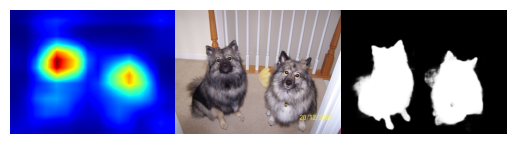

<Figure size 6400x2000 with 0 Axes>

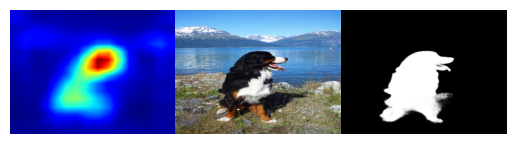

<Figure size 6400x2000 with 0 Axes>

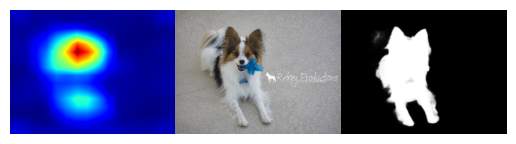

<Figure size 6400x2000 with 0 Axes>

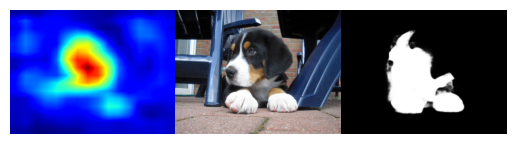

<Figure size 6400x2000 with 0 Axes>

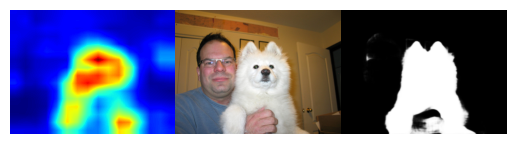

In [5]:
# root_dir
    # testset
        # images
        # gts
root_dir = 'test_data_vis'
testset = 'CoCA_part'
test_img_path = os.path.join(root_dir, 'images', testset)
test_gt_path = os.path.join(root_dir, 'gts', testset)
saved_root = os.path.join(root_dir, 'preds', testset)
test_loader = get_loader(test_img_path, test_gt_path, args.size, 1, istrain=False, shuffle=False, num_workers=0, pin=True)


for idx_batch, batch in enumerate(test_loader):
    inputs = batch[0].to(device).squeeze(0)
    gts = batch[1].to(device).squeeze(0)
    subpaths = batch[2]
    ori_sizes = batch[3]
    with torch.no_grad():
        cams, scaled_preds = model(inputs, vis='CAM')[-2:]


    num = len(scaled_preds)
    for inum in range(1, num):
        subpath = subpaths[inum][0]
        ori_size = (ori_sizes[inum][0].item(), ori_sizes[inum][1].item())
        if config.db_output_refiner or (not config.refine and config.db_output_decoder):
            res = nn.functional.interpolate(scaled_preds[inum].unsqueeze(0), size=ori_size, mode='bilinear', align_corners=True)
        else:
            res = nn.functional.interpolate(scaled_preds[inum].unsqueeze(0), size=ori_size, mode='bilinear', align_corners=True).sigmoid()
        subpath = subpath.replace('../images', 'preds')
#         sub_dir = '/'.join(subpath.split('/')[:-1])
#         os.makedirs(sub_dir, exist_ok=True)
    #     save_tensor_img(res, subpath)
    #     break

    print('Group {}:'.format(subpath.split(os.sep)[0]))
    for idx_image in range(scaled_preds.shape[0]):
        cam_map = torch.mean(cams[idx_image], dim=0)
        plt.figure(figsize=(64, 20))
        fg, (ax_cam, ax_image, ax_pred) = plt.subplots(1, 3)
        plt.subplots_adjust(wspace=0, hspace=0)

        ax_cam.imshow(torch.nn.functional.interpolate(cam_map.unsqueeze(0).unsqueeze(0), (600, 800), mode='bilinear').squeeze(), cmap='jet')
        ax_cam.axis('off')

        image_path = os.path.join(test_img_path, subpaths[idx_image][0][:-4] + '.png')
        if not os.path.exists(image_path):
            image_path = image_path[:-4] + '.jpg'
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        ax_image.imshow(cv2.resize(image, (800, 600), interpolation=cv2.INTER_LINEAR))
        ax_image.axis('off')

        tsr = torch.mean(scaled_preds[idx_image], dim=0)
        ax_pred.imshow(torch.nn.functional.interpolate(tsr.unsqueeze(0).unsqueeze(0), (600, 800), mode='bilinear').squeeze(), cmap='gray')
        ax_pred.axis('off')

        path_cam = os.path.join(saved_root, *subpath.split(os.sep)[-2:])
        os.makedirs(os.path.join(*path_cam.split(os.sep)[:-1]), exist_ok=True)
        path_cam = path_cam[:-4] + '_cam-{}.png'.format(idx_image)
#         cv2.imwrite(path_cam, cam_map)

        plt.savefig(path_cam, bbox_inches="tight", pad_inches=0)
        plt.show()
    print((('=' * 10) + '\n') * 5)
